In [1]:
!which python
!pip install numpy

/Users/xusu/anaconda3/envs/EDA/bin/python
Looking in indexes: http://mirrors.aliyun.com/pypi/simple/


In [2]:
import numpy as np

In [3]:
with open('ActivityNet/activity_net.v1-3.min.json') as f:
    import json
    json_data = json.load(f)

In [4]:
json_data.keys()

dict_keys(['taxonomy', 'version', 'database'])

In [5]:
json_data['taxonomy']

[{'parentName': 'Health-related self care',
  'nodeName': 'Applying sunscreen',
  'nodeId': 389,
  'parentId': 269},
 {'parentName': 'Health-related Self Care',
  'nodeName': 'Health-related self care',
  'nodeId': 269,
  'parentId': 270},
 {'parentName': 'Personal Care',
  'nodeName': 'Health-related Self Care',
  'nodeId': 270,
  'parentId': 2},
 {'parentName': 'Wrestling',
  'nodeName': 'Arm wrestling',
  'nodeId': 271,
  'parentId': 272},
 {'parentName': 'Participating in Sports, Exercise, or Recreation',
  'nodeName': 'Wrestling',
  'nodeId': 272,
  'parentId': 17},
 {'parentName': 'Vehicle repair and maintenance (by self)',
  'nodeName': 'Assembling bicycle',
  'nodeId': 273,
  'parentId': 56},
 {'parentName': 'Biking', 'nodeName': 'BMX', 'nodeId': 274, 'parentId': 275},
 {'parentName': 'Participating in Sports, Exercise, or Recreation',
  'nodeName': 'Biking',
  'nodeId': 275,
  'parentId': 17},
 {'parentName': 'Food and drink preparation ',
  'nodeName': 'Baking cookies',
  'no

In [6]:
# Now analyze the taxonomy 
p_dict = {}
n_dict = {}
for node in json_data['taxonomy']:
    if node['nodeName'] not in n_dict.keys():
        n_dict[node['nodeName']] = node['nodeId']
    else:
        assert n_dict['nodeName'] == node['nodeId']
    if node['parentName'] not in p_dict.keys():
        p_dict[node['parentName']] = node['parentId']
    else:
        assert p_dict[node['parentName']] == node['parentId']
print(f'There are {len(p_dict.keys())} parent classes and {len(n_dict.keys())} node classes.')        

There are 73 parent classes and 272 node classes.


In [7]:
# Now there is something strange, we all know that activityNet has 200 classes, but why 272 classes here?
# We will explore it later when dealing with the field 'database'.

In [8]:
annotation = json_data['database']
annotation

{'sJFgo9H6zNo': {'duration': 139.042,
  'subset': 'training',
  'resolution': '640x360',
  'url': 'https://www.youtube.com/watch?v=sJFgo9H6zNo',
  'annotations': [{'segment': [0.01, 123.42336739937599],
    'label': 'Fun sliding down'}]},
 'V1zhqaGFY2A': {'duration': 136.98,
  'subset': 'testing',
  'resolution': '658x480',
  'url': 'https://www.youtube.com/watch?v=V1zhqaGFY2A',
  'annotations': []},
 'JDg--pjY5gg': {'duration': 126.178,
  'subset': 'validation',
  'resolution': '1920x1080',
  'url': 'https://www.youtube.com/watch?v=JDg--pjY5gg',
  'annotations': [{'segment': [61.420442338881465, 64.56014561469672],
    'label': 'Beer pong'}]},
 'KsFid_YVsn0': {'duration': 235.13,
  'subset': 'testing',
  'resolution': '1920x1080',
  'url': 'https://www.youtube.com/watch?v=KsFid_YVsn0',
  'annotations': []},
 '-TmWR_keSfI': {'duration': 104.955,
  'subset': 'testing',
  'resolution': '1280x720',
  'url': 'https://www.youtube.com/watch?v=-TmWR_keSfI',
  'annotations': []},
 'u2uoYvo8J5s

In [9]:
print(f'There are {len(annotation.keys())} videos.')

There are 19994 videos.


In [10]:
class SegmentInstance():
    count = 0
    
    def __init__(self, action_label, video_id, start, end, duration):
        self.action_label = action_label
        self.video_id = video_id
        self.start = start
        self.end = end
        self.duration = self.end - self.start
        self.coverage = self.duration / duration
    @classmethod
    def inc_count(cls):
        cls.count += 1
    @classmethod
    def reset_count(cls):
        cls.count = 0

In [11]:
class VideoInstance():
    count = 0
    
    def __init__(self,
                 video_id,
                 duration=None,
                 subset=None,
                 resolution=None,
                 url=None,
                 **kwargs):
        self.segments = []
        self.video_id = video_id
        self.duration = duration
        self.subset = subset
        self.resolution = resolution
        self.url = url
        
    @classmethod
    def inc_count(cls):
        cls.count += 1
    @classmethod
    def reset_count(cls):
        cls.count = 0
        
    def add_seg(self, seg_instance):
        self.segments.append(seg_instance)
    
    def get_num_seg(self):
        return len(self.segments)

In [12]:
# Now read all the action instance and get some insights of them
all_segs = []
all_videos = []
VideoInstance.reset_count()
SegmentInstance.reset_count()

for video_id, video_info in annotation.items():
    new_video = VideoInstance(video_id, **video_info)
    VideoInstance.inc_count()
    for seg in video_info['annotations']:
        new_seg = SegmentInstance(seg['label'],
                                  video_id,
                                  seg['segment'][0], 
                                  seg['segment'][1],
                                  video_info['duration']
                                 )
        new_video.add_seg(new_seg)
        SegmentInstance.inc_count()
        all_segs.append(new_seg)
    all_videos.append(new_video)
        
assert len(all_segs) == SegmentInstance.count
assert len(all_videos) == VideoInstance.count

print(f'There are {SegmentInstance.count} segments and {VideoInstance.count} videos.'
     f'Therefore the global average segments for one video is {(SegmentInstance.count / VideoInstance.count)}')

There are 23064 segments and 19994 videos.Therefore the global average segments for one video is 1.1535460638191457


In [13]:
%time !pip install matplotlib

Looking in indexes: http://mirrors.aliyun.com/pypi/simple/
CPU times: user 8.71 ms, sys: 6.92 ms, total: 15.6 ms
Wall time: 689 ms


In [14]:
import matplotlib

In [15]:
# Now lets check if all segments are within taxonomy and how many are untouched
# Besides, I want to plot the distribution of seg lengths and its coverage
seg_lengths = []
coverages = []
all_classes = set(n_dict.keys())
class_distribution = []
untouched_action = []
for seg in all_segs:
    if seg.action_label in n_dict.keys():
        class_distribution.append(seg.action_label)
print(f'{len(all_classes - set(class_distribution))} not touched')
print(f'{len(set(class_distribution))} appeared.')

72 not touched
200 appeared.


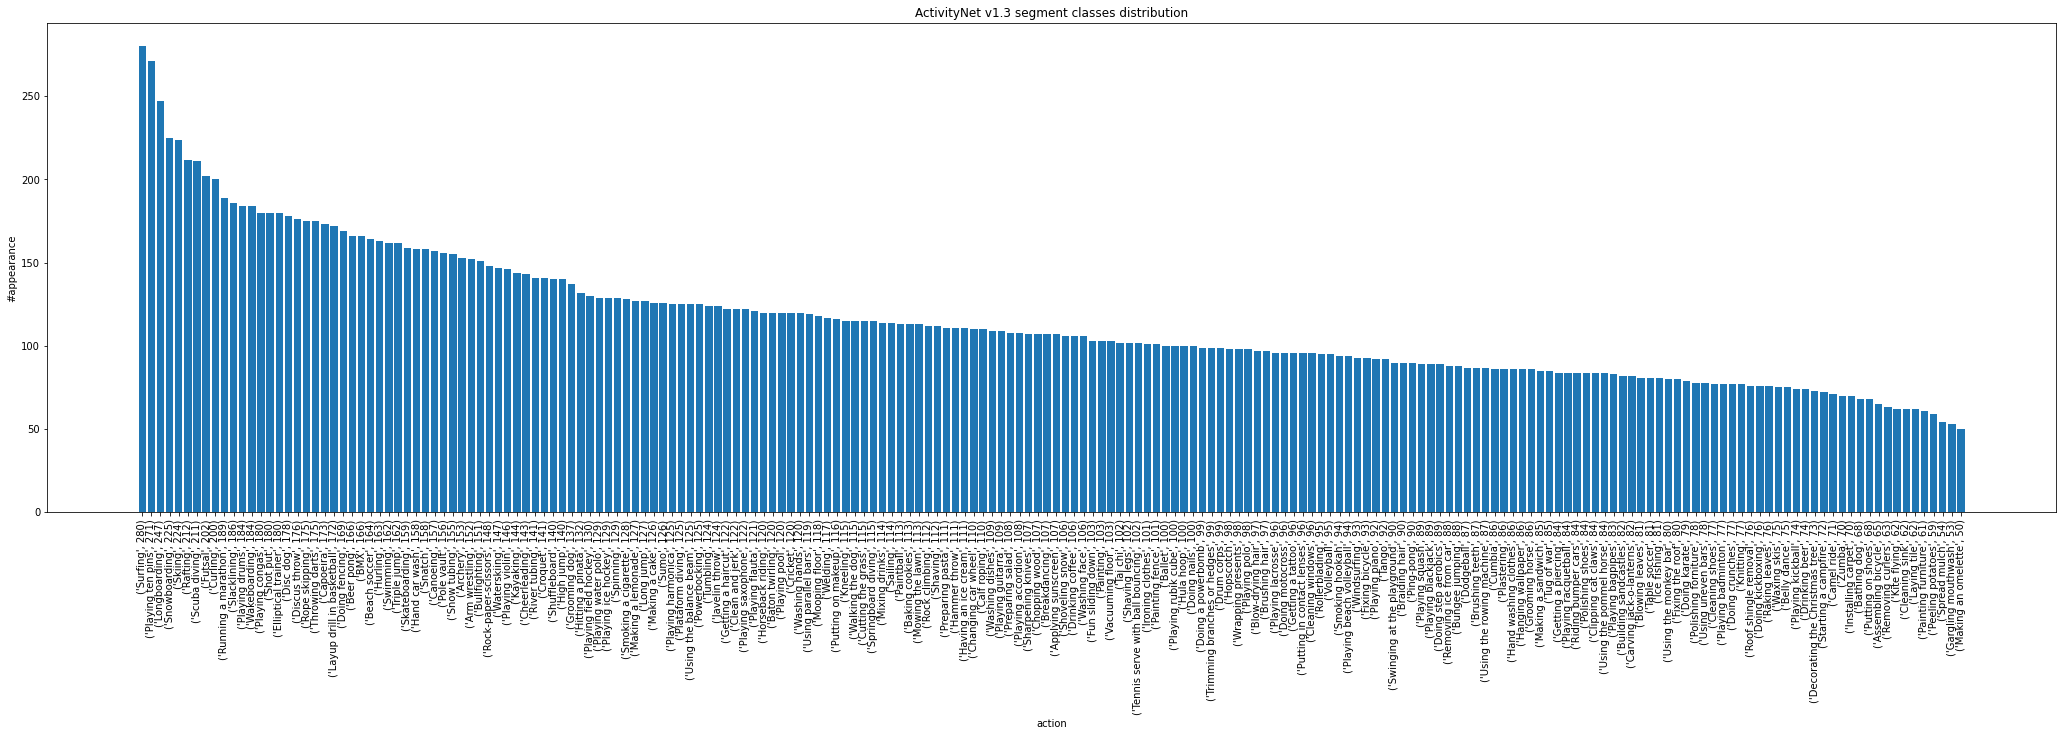

In [16]:
from collections import Counter
from matplotlib import pyplot as plt
result = Counter(class_distribution)

plt.figure(figsize=(36,9))
plt.clf()
plt.title('ActivityNet v1.3 segment classes distribution')
plt.xlabel('action')
plt.ylabel('#appearance')

plt.bar(range(len(result.keys())),sorted(result.values(), reverse=True))

plt.xticks(range(len(result.keys())),sorted(result.items(), key=lambda d: d[1], reverse=True) , rotation=90)
plt.show()

In [17]:
# Some basic stats analyze
appearance = np.array([ num for num in result.values()])
print(f'mean: {np.mean(appearance)}, std: {np.std(appearance)}')

mean: 115.32, std: 40.55561120239714


In [18]:
# I am curious how many kind of classes in average are there in all videos
num_classes_per_video = []
num_segs_per_video = []
for video in all_videos:
    if video.subset != 'training':
        continue
    classes = {}
    num_segs_per_video.append(video.get_num_seg())
    for seg in video.segments:
        if seg.action_label not in classes.keys():
            classes[seg.action_label] = 1
        else:
            classes[seg.action_label] += 1
    if not 0 <= len(classes.keys()) <= 1:
        print(f'{video.video_id} has {(classes.keys())}')
    num_classes_per_video.append(len(classes.keys()))
print(Counter(num_classes_per_video))
print(Counter(num_segs_per_video))
print(f'avg #class per video is {np.mean(num_classes_per_video)}\n'
     f'avg #seg per video is {np.mean(num_segs_per_video)}\n')

# training:
# avg #class per video is 1.0005985634477255
# avg #seg per video is 1.5373104549082204

# validation:
# avg #class per video is 1.0014210312626879
# avg #seg per video is 1.5537961835160374
#
# As we can see nearly every video has only on kind of action
# And most of them are synonyms.

F2x2fynkbAQ has dict_keys(['Polishing shoes', 'Cleaning shoes'])
xpEbejnuGEY has dict_keys(['Polishing forniture', 'Painting furniture'])
nMK_jVy5ZuI has dict_keys(['Long jump', 'Triple jump'])
eUvvxpAK3_8 has dict_keys(['Polishing shoes', 'Cleaning shoes'])
kUlwaBYvyBI has dict_keys(['Polishing forniture', 'Painting furniture'])
GvDu_0ktsJ0 has dict_keys(['Preparing salad', 'Preparing pasta'])
Counter({1: 10018, 2: 6})
Counter({1: 7551, 2: 1326, 3: 481, 4: 268, 5: 153, 6: 97, 7: 51, 8: 35, 9: 19, 10: 15, 11: 11, 13: 4, 12: 4, 15: 3, 18: 2, 23: 2, 19: 1, 20: 1})
avg #class per video is 1.0005985634477255
avg #seg per video is 1.5373104549082204



23064


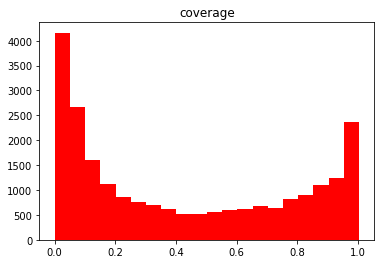

In [19]:
# Now I also want to find out the coverage distribution of segments
# This is extremly important if using an anchor based model
print(len(all_segs))
coverages = [seg.coverage for seg in all_segs]
n, bins, patches = plt.hist(coverages,bins=20,color='r')
plt.title("coverage")
plt.show()
# This is strange, it is not Gaussian-ish

KaGGtAhiH64 213.113:
20.613089100434767->126.33828803492277: Playing rubik cube
93.42383931003498->128.66557228819767: Playing rubik cube
131.6577948995511->162.24495937116396: Playing rubik cube
166.2345895196352->212.91274376417235: Playing rubik cube
v_Vg4a8igc0 36.73:
0->36.733968: Bathing dog
O9crPOB_9tE 227.649:
0.01->85.59012885179408: Surfing
64.99167460530421->227.44843400000002: Surfing
1v5HE_Nm99g 226.178:
0.01->226.201: Sumo
_mupI51ie9A 69.15:
0.2->68.94902494331066: Playing racquetball
24.48803154602184->28.695226393135727: Playing racquetball
34.3048195226209->47.03428085491419: Playing racquetball
59.11648144149766->68.949023: Playing racquetball
cC1nvRqyXWs 6.43:
0->6.431926: Ironing clothes
2Mj26IwwEiY 211.07:
0.2->210.86938775510205: Hanging wallpaper
181.1979748854382->188.09137629445843: Hanging wallpaper
1R25VGmqS9o 72.19:
0->72.190838: Playing field hockey
9SEc3QVBCo4 24.032:
0->24.032652: Roof shingle removal
_4CLYKFzmoY 231.78:
0->231.7815873015873: Playing viol

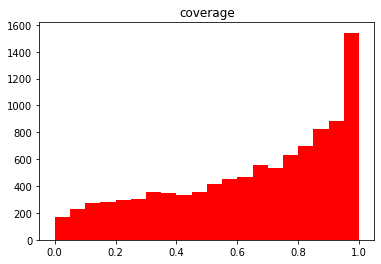

In [38]:
# now I want to find out the coverage of all segments in videos
coverages = []
has_overlap = 0
for video in all_videos:
    if video.subset != 'training':
        continue
    c = 0
    for seg in video.segments:
        c += float(seg.coverage)
    if c > 1:
        has_overlap += 1
        print(f'{video.video_id} {video.duration}:')
        for seg in video.segments:
            print(f'{seg.start}->{seg.end}: {seg.action_label}')
        continue
    coverages.append(c)
print(f'{has_overlap}/{has_overlap + len(coverages)}:{has_overlap / len(coverages)} has overlapping.')
plt.clf()
n, bins, patches = plt.hist(coverages,bins=20,color='r')
plt.title("coverage")
plt.show()

# This really tells something, there seems to be some miss-labeling in the annotation
# For example
# 8JKK6JayDeA 220.66:
# 0.2->220.405: Snatch
# 32.350811232449296->46.11711388455538: Snatch
# 0.2->220.405: Snatch
# 0.2->220.405: Snatch
# 0.2->220.405: Snatch
# 0.2->220.405: Snatch
# 0.2->220.405: Snatch
# 0.2->220.405: Snatch
# 0.2->220.405: Snatch
# 0.2->220.405: Snatch
# 0.2->220.405: Snatch
# 0.2->220.405: Snatch
# 0.2->220.405: Snatch
# 0.2->220.405: Snatch
# 182.4035101404056->201.67633385335412: Snatch
#

In [39]:
# Besides those outliers, the distribution is like stepping up, with mean and std
print(np.mean(coverages), np.std(coverages))

0.6496829431166606 0.28360261504665024
